# **This notebook is written by Rachel Xie (z5141973)**

This notebook contains two model explainations:
1. Deep CNN model
2. Ensembled model

# Problem Statement
In the modern world, driving is one of the most essential modes of transportation. In order to prevent drivers from disobeying traffic signs, avoid dangers, and promote safer driving, this computer vision project focuses on developing generic models that employ forward-sensing cameras to recognise traffic signals.

# Data Resource
This notebook is pre-run and already contains the outputs. If you want to re-run this notebook, please upload this notebook to Kaggle and add the dataset from "https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign", so that data can be read from the correct folder path.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import *
import warnings
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

# Exploratory Analysis of Data or RL Tasks
## Dataset Details
This dataset contains 43 classes of images and more than 50,000 images. In addition, the images are in RGB with 30x30 pixels and the test folder contains 12.6k images. The size of images are between 30 x 25 and 266 x 232.

The number of training images of all the classes are shown in the figure. The difference between the least number of class images of "Dangerous Curve Left" and the largest number of class images of "Speed limit (50km/h)" is around 2000, which is not very significant compared to the number of the total images (50,000). Thus, resampling is not neccessary in this dataset.

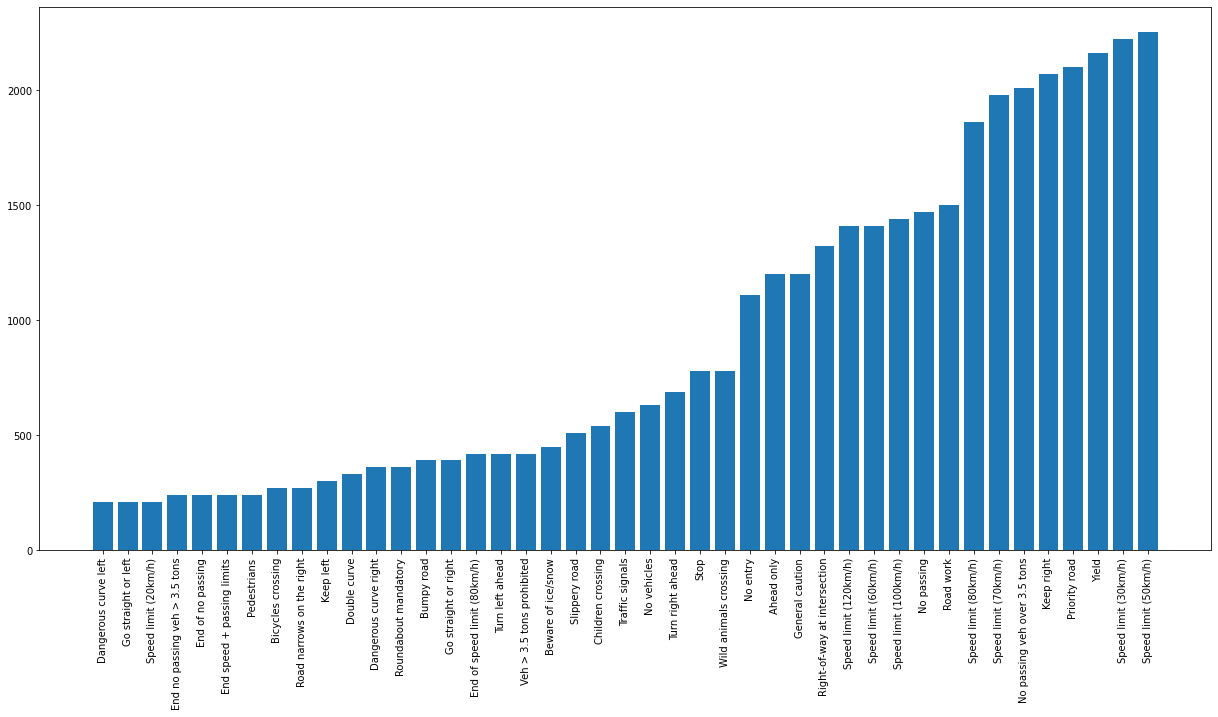

In [ ]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

trainFolder = '/kaggle/input/gtsrb-german-traffic-sign/Train'
trainFolders = os.listdir(trainFolder)

trainNumber = []
classNum = []

for folder in trainFolders:
    trainFiles = os.listdir(trainFolder + '/' + folder)
    trainNumber.append(len(trainFiles))
    classNum.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipList = zip(trainNumber, classNum)
sortedPairs = sorted(zipList)
tuples = zip(*sortedPairs)
trainNumber, classNum = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(classNum, trainNumber)
plt.xticks(classNum, rotation='vertical')
plt.show()

## Challenging Aspect
However, there is one challenging point that the size of the provided images are different. If the image size is set to be the largest size (266 x 232), the training speed will be drawn back. This can be caused by longer time processing for large images and by the RAM memory limitation, which can be exceeded due to large batch size. Thus, proper preprocessing methods are needed to increase the training speed while maintaining the test accuracy.

## Preprocessing
The input images are resized to 30 and centre cropped, so that the model can be trained faster on smaller images. There is one problem caused by this resizing, which will be discussed in discussion and future improvement part.

The image matrix values are normalized to ensure optimal comparisons across data acquisition methods and texture instances, making the model less sensitive to scale of features, and able to avoid exploding/vanishing gradient.

The corresponding code for preprocessing is in function "setTransform()"

# Model and Methods
There are two main models included in this notebook, which will be described seperatly in the following paragraphs.

## Code Explaination
The following code block is the base class "Model" for models "CNN, DNN, EfficientCNN", containing abstract and default functions and variables. The factory design pattern is used here to provide a clear and tidy coding format. "startTraining()" function is the main function to run the training process.

In [ ]:
basePath = '../input/gtsrb-german-traffic-sign/'
data = pd.read_csv('../input/gtsrb-german-traffic-sign/Train.csv', usecols=['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path'])
trainData = data.iloc[:, :-2]
trainLabel = data.iloc[:, -2]
trainset = []
testData = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')
testLabel = testData["ClassId"].values
testset = []
resultEnsemble = []

class Model:
    def __init__(self, className):
        self.transform = None
        self.trainData = trainData
        self.trainLabel = trainLabel
        self.testLabel = testLabel
        self.trainset = []
        self.testset = []
        self.validationset = []
        self.name = className
        self.model = None
        self.history = None
        self.losses = []
        self.optimizer = None
        self.PATH = None
        self.testTransform = None
        self.XTrain = None
        self.YTrain = None
        self.XVal = None
        self.YVal = None
        self.XTest = None
        self.YTest = None
        self.imageSize = None
        self.batchSize = None
        self.epoch = None
        self.YPred = None
    
    # Set the transformation steps for training and testing
    @abstractmethod
    def setTransform(self):
        pass
    # Create training, validation and testing sets
    def createSets(self):
        print(f'create sets for model: {self.name}')
        for i in range(len(data['Path'])):
            imgPath = data['Path'][i]
            try:
                image = Image.open(basePath + imgPath).convert('RGB')
                self.trainset.append(self.transform(image).numpy())
            except:
                print("Error in " + imgPath)
                self.trainLabel.pop(i)
        self.XTrain, self.XVal, self.YTrain, self.YVal = train_test_split(self.trainset, self.trainLabel.values, test_size=0.2, shuffle=True)
        print(f'Splitting data into trainset of size {len(self.XTrain)} and validationset of size {len(self.XVal)}')
        for imgPath in testData['Path']:
            try:
                image = Image.open(basePath + imgPath).convert('RGB')
                self.testset.append(self.testTransform(image).numpy())
            except:
                print("Error in " + imgPath)
        self.XTrain = np.array(self.XTrain).reshape(len(self.XTrain), self.imageSize, self.imageSize, 3)
        self.XVal = np.array(self.XVal).reshape(len(self.XVal), self.imageSize, self.imageSize, 3)
        self.YTrain = np.array(self.YTrain).astype(np.float)
        self.YVal = np.array(self.YVal).astype(np.float)
        self.XTest = np.array(self.testset).reshape(len(self.testset), self.imageSize, self.imageSize, 3)
        self.YTest = np.array(self.testLabel).astype(np.float)
    # Set model layers, optimizations
    @abstractmethod
    def setModel(self):
        pass
    # Plot training and validation result visualization
    def plotTrain(self):
        plt.figure(0)
        plt.plot(self.history.history['accuracy'], label=self.name + 'training accuracy')
        plt.plot(self.history.history['val_accuracy'], label=self.name + 'validation accuracy')
        plt.title('Accuracy')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.legend()

        plt.figure(1)
        plt.plot(self.history.history['loss'], label=self.name + 'training loss')
        plt.plot(self.history.history['val_loss'], label=self.name + 'validation loss')
        plt.title('Loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        
    def runTest(self):
        self.YPred = self.model.predict(self.XTest)
        return self.YPred
    def startTraining(self):
        self.setTransform()
        self.createSets()
        self.setModel()
        self.plotTrain()

The following code block shows the data augmentation, model layers and optimizations for Deep CNN model.

## Data Augmentation for both Deep CNN and Ensembled Model
In file "cnn.ipynb", there is no data augmentation, to improve the training and testing accuracy, input training images are randomly rotated by 10 degress to increase the semantic coverage of the dataset. The reason why not to use random flip horizontally or vertically is it may result in misclassification when number "6" is flipped to "9" and reduces the training efficiency and testing accuracy.

## Deep CNN Model Selection
The following class "DNN" contains the customized codes for Deep CNN model. This model is built based on the basic CNN model presented by other group member in file "cnn.ipynb". It is chosen to further improve the training and test accuracy by increasing the convolutional layer size and the kernel size.

## Deep CNN Model Layers Adjustment
Compared to the basic CNN model in file "cnn.ipynb", Deep CNN increases the filter size and kernel size of the Convolutional layer from 16 to 64/128 and 3 to 5 respectively. By increasing these two parameters, more features are extracted into the model for higher training accuracy. This may lead to overfitting problem and extends the training time.

To solve these problems, BatchNormalization layers are added to normalize values among layers and speed up the training speed. Three more Dropout layers are used to randomly drop out neurons to prevent overfitting problem, whose values are adjusted from 0.3 to 0.5. If dropout is too low, the overfitting problem cannot be solved. Dropout value cannot be too high, otherwise the training accuracy will be reduced.

As for hyperparameters, "l1_l2" applies both l1 and l2 regularization penalties to reduce the weights. Activation of the first Dense layer is chosen as "Relu" to speed up the training process and to acheive better performance for its quick convergence and more strict saturation requirement compared to "sigmoid" activation. Then "softmax" activation is used in the second Dense layer as an output layer to compute the probabilty for this multiclass problem.

## Deep CNN Model Optimizer
Early stopping is used to stop the training if there is no improvement in 20 epochs, and learning rate is set to be reduced to (0.1*learning rate) if there is no improvement in 8 epochs. These callbacks are applied to train the model for higher efficiency and adjust the training parameter values dynamically. 

Furthermore, the "Adam" optimizer, combining the strenghs of both Momentum and Root Mean Square Propagation, is used to provide optimized gradient descent. "Adam" is chosen for its faster computation time and fewer parameters for tuning. The learning rate is set to "1e-3", so that it is not too small to extend training time and not too large, resulting in undesirable divergent behavior in loss function.

## Deep CNN Model Training Adjustment
"loss" is set as "sparse_categorical_crossentropy", for the input labels are integers rather than in one hot representation. "Accuracy" can be a good metrics for this dataset, since the dataset is not imbalanced. And batch size is set to "128" for quicker training process, and the epoch number is set to 50, since there is little improvement on performance after 50 epochs based on the plotted accuracy figure.

In [ ]:
class DNN(Model):
    def __init__(self):
        Model.__init__(self, "DNN")
        self.imageSize = 30
    def setTransform(self):
        self.transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.Resize(self.imageSize),
            transforms.CenterCrop(self.imageSize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
        self.testTransform = transforms.Compose([
            transforms.Resize(self.imageSize),
            transforms.CenterCrop(self.imageSize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
    def setModel(self):
        self.model = Sequential()
        self.model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = 'relu', padding='same',
                         input_shape = (self.imageSize, self.imageSize, 3), data_format = 'channels_last',
                         kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))
        self.model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", strides = (2, 2),
                        kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))
        self.model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.3))

        self.model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu' ,
                         kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
        # # replace maxpooling with conv2d
        self.model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = "same",
                         kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3), strides = (2, 2)))
        self.model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
        self.model.add(BatchNormalization())

        self.model.add(Flatten())
        self.model.add(Dropout(0.3))
        self.model.add(Dense(256, activation = 'relu',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        self.model.add(Dense(43, activation = 'softmax',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
        self.model.summary()
        
        callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)
        opt = Adam(learning_rate = 1e-3)
        self.model.compile(optimizer = opt,
                      loss = 'sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        # 30
        self.history = self.model.fit(self.XTrain ,self.YTrain,  batch_size = 128, 
         epochs=50, validation_data = (self.XVal, self.YVal),
          callbacks=[callback, reduce_lr], shuffle = True)


The models "CNN" and "EfficientCNN" presented below are from other group members' notebooks, the details can be found in "cnn.ipynb" and "efficient-cnn.ipynb" notebooks.

In [ ]:
class CNN(Model):
    def __init__(self):
        Model.__init__(self, "CNN")
        self.imageSize = 30
    def setTransform(self):
        self.transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.Resize(self.imageSize),
            transforms.CenterCrop(self.imageSize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.testTransform = transforms.Compose([
            transforms.Resize(self.imageSize),
            transforms.CenterCrop(self.imageSize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
    def setModel(self):
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=self.XTrain.shape[1:]))
        self.model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
        self.model.add(MaxPool2D(pool_size=(2, 2)))
        self.model.add(BatchNormalization(axis=-1))
        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(rate=0.5))
        self.model.add(Dense(43, activation='softmax'))

        #Compilation of the model
        lr = 0.001
        epochs = 30 #30

        self.model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy']
        )
        self.history = self.model.fit(self.XTrain, self.YTrain, batch_size=32, epochs=epochs, validation_data=(self.XVal, self.YVal))

class EfficientCNN(Model):
    def __init__(self):
        Model.__init__(self, "efficientCNN")
        self.imageSize = 30
    def setTransform(self):
        self.transform = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.Resize(self.imageSize),
            transforms.CenterCrop(self.imageSize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.testTransform = transforms.Compose([
            transforms.Resize(self.imageSize),
            transforms.CenterCrop(self.imageSize),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # from imagenet
        ])
    def setModel(self):
        self.model = Sequential()
        self.model.add(BatchNormalization(input_shape=(self.imageSize, self.imageSize, 3))),
        self.model.add(Conv2D(16,3,activation='relu'))
        self.model.add(SpatialDropout2D(0.05))

        self.model.add(BatchNormalization())
        self.model.add(Conv2D(32,3, activation = 'relu'))
        self.model.add(SpatialDropout2D(0.05))
        self.model.add(MaxPool2D(pool_size=(2, 2)))

        self.model.add(BatchNormalization())
        self.model.add(Conv2D(64,3, activation = 'relu'))
        self.model.add(SpatialDropout2D(0.05))

        self.model.add(BatchNormalization())
        self.model.add(Conv2D(128,3, activation = 'relu'))
        self.model.add(SpatialDropout2D(0.05))
        self.model.add(MaxPool2D(pool_size=(2, 2)))

        self.model.add(BatchNormalization())
        self.model.add(Conv2D(256,3, activation = 'relu'))
        self.model.add(SpatialDropout2D(0.05))

        self.model.add(BatchNormalization())
        self.model.add(Conv2D(1024,1, activation = 'relu'))
        self.model.add(SpatialDropout2D(0.05))

        self.model.add(GlobalAveragePooling2D())
        self.model.add(Dense(256, activation='relu'))
        self.model.add(Flatten())
        self.model.add(Normalization())
        self.model.add(Dropout(0.5))
        self.model.add(Dense(43, activation='softmax'))

        # 20
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        epochs = 20
        self.history = self.model.fit(self.XTrain, self.YTrain, batch_size=32, epochs=epochs, validation_data=(self.XVal, self.YVal))

The following block shows the structure of the ensembled model and how it combines the results.

## Ensembled Model Selection & Structure
Based on the group model results, it may achieve a higher test accuracy if five models' results can be appropriately combined together. Thus, ensembled model is used to combine the results from the top threee models in two situations.

If the results from the top three models are all different, the ensembled model finds the model that has the highest test accuracy (shown in line 14 in the following block), and chooses its result as the output. Otherwise, if there is a result with maximum votes, the ensembled model uses that result as the output.

Thus, the ensembled model can achieve the test accuracy that is higher than the test accuracy of any ensembled individual model. The test accuracies and loss visiualizations of ensembled individual models are shown in the output of the following code block.

create sets for model: efficientCNN
Splitting data into trainset of size 31367 and validationset of size 7842


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for 

Epoch 1/20
981/981 [==============================] - 67s 66ms/step - loss: 2.4781 - accuracy: 0.2995 - val_loss: 1.2831 - val_accuracy: 0.5858
Epoch 2/20
981/981 [==============================] - 63s 65ms/step - loss: 1.1483 - accuracy: 0.6355 - val_loss: 0.5725 - val_accuracy: 0.8131
Epoch 3/20
981/981 [==============================] - 64s 65ms/step - loss: 0.7032 - accuracy: 0.7755 - val_loss: 0.3628 - val_accuracy: 0.8833
Epoch 4/20
981/981 [==============================] - 63s 65ms/step - loss: 0.5022 - accuracy: 0.8422 - val_loss: 0.2595 - val_accuracy: 0.9098
Epoch 5/20
981/981 [==============================] - 64s 65ms/step - loss: 0.3908 - accuracy: 0.8766 - val_loss: 0.2432 - val_accuracy: 0.9167
Epoch 6/20
981/981 [==============================] - 64s 65ms/step - loss: 0.3093 - accuracy: 0.9043 - val_loss: 0.1841 - val_accuracy: 0.9415
Epoch 7/20
981/981 [==============================] - 64s 65ms/step - loss: 0.2547 - accuracy: 0.9223 - val_loss: 0.1653 - val_accuracy:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 64)        4864      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.float` is a deprecated alias for 

Epoch 1/30
981/981 [==============================] - 41s 41ms/step - loss: 1.8458 - accuracy: 0.5181 - val_loss: 0.6237 - val_accuracy: 0.8037
Epoch 2/30
981/981 [==============================] - 39s 40ms/step - loss: 0.4645 - accuracy: 0.8525 - val_loss: 0.2853 - val_accuracy: 0.9067
Epoch 3/30
981/981 [==============================] - 39s 40ms/step - loss: 0.2457 - accuracy: 0.9214 - val_loss: 0.2529 - val_accuracy: 0.9180
Epoch 4/30
981/981 [==============================] - 38s 39ms/step - loss: 0.1861 - accuracy: 0.9389 - val_loss: 0.1932 - val_accuracy: 0.9398
Epoch 5/30
981/981 [==============================] - 40s 41ms/step - loss: 0.1445 - accuracy: 0.9526 - val_loss: 0.2085 - val_accuracy: 0.9350
Epoch 6/30
981/981 [==============================] - 39s 40ms/step - loss: 0.1215 - accuracy: 0.9612 - val_loss: 0.1819 - val_accuracy: 0.9431
Epoch 7/30
981/981 [==============================] - 40s 40ms/step - loss: 0.1113 - accuracy: 0.9629 - val_loss: 0.1458 - val_accuracy:

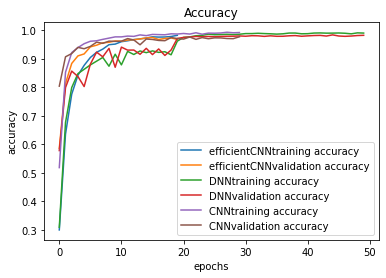

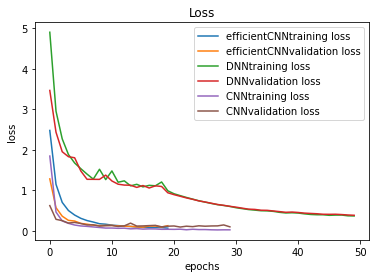

In [ ]:
dnn = DNN()
cnn = CNN()
ecnn = EfficientCNN()
testResult = []
modelList = [ecnn, dnn, cnn]
accResult = []
highest = 0
accHighest = 0
for i in range(len(modelList)):
    model = modelList[i]
    model.startTraining()
    testResult.append(model.runTest())
    accuracy = accuracy_score(model.YTest, np.argmax(model.YPred, axis=1))
    if accuracy > accHighest:
        accHighest = accuracy
        highest = i
    print("{} accuracy score is: {}".format(model.name, accuracy))
print("The highest accuracy is model: {}".format(modelList[highest].name))

# Results
## Deep CNN Model Result
The two figures above show the training/validation accuracy and loss of Deep CNN (DNN) model compared to other CNN models. Deep CNN model obtains the highest test accuracy as "0.917", while basic CNN obtains "0.896" and EfficientCNN obtains "0.890".

Although Deep CNN takes the longest training time, it reaches higher test accuracy score among these three. This is because it has a deeper convolutional layer, which has more filters and larger kernel size, helping extract and analyse more features. Moreover, the difference between test and train accuracy is the smallest, which indicates the added Dropout and BatchNormalization layer, randomly rotated input images and the optimizer have successfully reduced the overfitting effect.

However, a DNN solution achieves a higher test accuracy from site "https://www.kaggle.com/code/whitelord/german-sign-detection-dnn-solution". This model has less training time for it has a slightly smaller filter size as 32 instead of 64. The other main difference is that it uses one hot encoding instead of label encoding, which prevents the ranking between values and increases the train and test accuracy.

## Ensembled Model Result
As printed in output below, the test accuracy of the ensembled model is the highest "0.929". This is because it uses the result of the model that has the highest test accuracy as default and improves the result by considering other models' outputs.

In [ ]:
from sklearn.metrics import accuracy_score
YTest = modelList[0].YTest
YPredEnsembled = []

for i in range(len(YTest)):
    compare = []
    for j in range(len(modelList)):
        compare.append(np.argmax(modelList[j].YPred[i]))
    if len(set(compare)) == len(compare):
        YPredEnsembled.append(np.argmax(modelList[highest].YPred[i]))
    else: 
        YPredEnsembled.append(max(set(compare), key = compare.count))

In [ ]:
accScore = accuracy_score(modelList[0].YTest, YPredEnsembled)

print(f"The test accuracy score is: {accScore}")

The test accuracy score is: 0.9292953285827396


# Discussion
The Deep CNN achieves a higher test accuracy after adjusting the model layers, adding optimizer and preprocessing based on the basic CNN model. The ensembled model, combining the strengths of all models, reaches the highest test accuracy among all models.

## Common Disadvantage and Future Improvment
One common disadvantage of the resizing the image in preprocessing is that there are images with large size, like 90, which can lose lots of important information after resizing and cropping to size 30. This can be further improved by resizing the images to a larger size and ignoring the black paddings for smaller images.

## Advantages/Disadvantages/Future Improvement of Deep CNN Model
This model improves the train and test accuracy by increasing the kernal size and filter numbers. It also deals with overfitting problem well by adding Dropout and BatchNormalization layer, using l1_l2 regularization in Convolutional layer and adding Adam optimizer. Moreover, it allows the parameter to be adjusted dynamically during training by applying callbacks. 

However, the number of filters are too large, resulting in longer training time. If the dataset becomes larger, the training time can be painful. It also does not use one hot encoding but uses label encoding instead, which may cause ranking problem in higher numebrs. 

For future improvements, it can lower the number of Convolutional layer filters to speed up the training process and use one hot encoding instead to avoid ranking problem.

## Advantages/Disadvantages/Future Improvement of Ensembled Model
This model ensembles the results of provided model group and can achieve the highest test accuracy among these models. The code of this model is well structured, so that it will not be limited by the number of input models, and the input model has flexible functions and self parameters to change the layers or do the customization.

The disadvantage of this model is that it needs to train all the models and store their results together to get the final result. This can draw back the training efficiency and become memory costing if the dataset is large.

The future improvement can be constructing a linear layer to simultaneously train the weights of each model's output, so that the results of each model do not need to be stored and the traiing time can be reduced.